In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib import cm
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap


import visualizations as viz_util
import project as proj
# import pointnets as ptn

%matplotlib notebook

np.set_printoptions(linewidth=120)

In [2]:
%matplotlib notebook

In [3]:
# dataset = trn.get_dataset('3dshapes', train=None, labeled=True, device='cpu')
# len(dataset)

In [5]:
M = trn.Run_Manager() # can pass arg with path
M.filter(lambda r: '3ds' in r.name and 't3ds' not in r.name)
M.filter(lambda r: not sum(x in r.name for x in {'12h', '6h', '4h','pvae'}))
M.filter(lambda r: sum(x in r.name for x in {'12b1'}))
# M.filter(lambda r: sum(x in r.name for x in {'conv'}))
pass

Found 358 runs
Auto parsing failed with: test-cmd_200517-145235
Auto parsing failed with: test-cmd_200517-153056
Auto parsing failed with: test-cmd_200517-164029
Auto parsing failed with: test-cmd_200517-164335
Auto parsing failed with: test-cmd_200517-164456
Auto parsing failed with: test-cmd_200517-170332
Auto parsing failed with: test-cmd_200517-170424
Auto parsing failed with: test-cmd_200517-170453
Auto parsing failed with: test-pycharm_200519-023532
Auto parsing failed with: test-pycharm_200519-023651
Auto parsing failed with: test-pycharm_200519-023741


In [6]:
M.show()

  0) 3ds-ae-12b1-12attn_0000-6334436-03_200508-001046
  1) 3ds-ae-12b1-conv_0005-6337809-01_200509-120419
  2) 3ds-ae-12b1-dbl_0005-6337809-02_200509-120410
  3) 3ds-ae-12b1-dbl_0052-6286534-01_200429-031808
  4) 3ds-ae-12b1-dislib_0007-6337835-00_200509-125920
  5) 3ds-ae-12b1_0006-6241674-05_200414-020822
  6) 3ds-ae-12b1_0007-6241675-00_200414-020856
  7) 3ds-ae-12b1_0007-6241675-01_200414-020851
  8) 3ds-ae-12b1_0015-6243020-00_200414-174614
  9) 3ds-ae-12b1_0015-6243020-01_200414-174746
 10) 3ds-ae-12b1_0052-6286534-00_200429-030431
 11) 3ds-wae-12b1_0006-6241674-04_200414-020822


In [7]:
run = M[1]
run.name

'3ds-ae-12b1-conv_0005-6337809-01_200509-120419'

In [8]:
run.load_into('results.pth.tar')

In [7]:
print(run.results.keys())
print(run.results['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [8]:
run.load_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [9]:
A = trn.get_config()
A.din = (3, 64, 64)
A.dout = A.din
model, = trn.load(run.name, config=A, get_data=None, update_config=True) # for loading only the model
print(model)

load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1-conv_0005-6337809-01_200509-120419\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [10]: 64


    output_nonlin --> nonlin: elu (in parent)
    residual: False (by default)
      conv_kwargs (type=dict): 
  Creating branches[7] (type=norm-ada-in)
    style_dim --> din: 1
    features: 64
    pixelwise: False (by default)
    Creating net (type=mlp) (mod=normal) (in parent)
      latent_dim: 64
      min_log_std: None (by default)
      input_dim --> din: 1
      output_dim --> dout: 128
      hidden_dims --> branch_hidden (type=list): 
[0]: 64
[1]: 128
      nonlin: elu (in parent)
      output_nonlin: None (in parent)
  Creating layers[7] (type=deconv-layer)
    in_channels: 64
    out_channels: 64
    factor: 1
    size: None (by default)
    kernel_size: None (by default)
    stride: 1 (by default)
    padding: 1 (by default)
    dilation: 1 (by default)
    output_padding: 0 (by default)
    din: (64, 16, 16)
    dout: (3, 64, 64) (in parent)
    up_type: bilinear (in parent)
    norm: group (in parent)
    nonlin: elu (in parent)
    output_nonlin --> nonlin: elu (in paren

)


In [9]:
X = run.results['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

In [6]:
with torch.no_grad():
    raw_Q = model.encode(X)
    if isinstance(raw_Q, distrib.Distribution):
        Q = raw_Q.mean
    else:
        Q = raw_Q
    rec = model.decode(raw_Q)
Q.shape, rec.shape

NameError: name 'model' is not defined

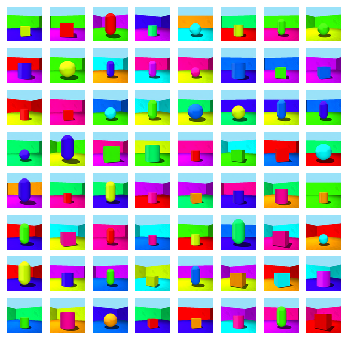

In [12]:
util.show_imgs(rec[:64])
pass

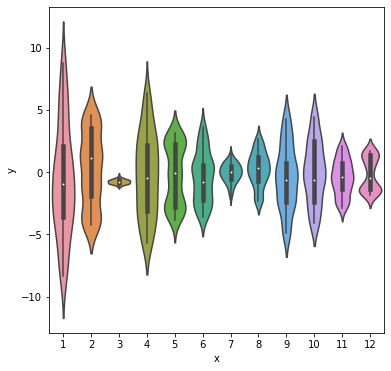

In [13]:
util.plot_distribs(Q)
pass

In [10]:
def save_fig(name):
    plt.savefig(f'figures/{name}.png')
    plt.savefig(f'figures/{name}.pdf')
    print(name, 'saved')

In [3]:
shapes3d = '''
3ds-ae-12b1-conv_0005-6337809-01_200509-120419
3ds-ae-4b3-dislib_0009-6337837-00_200509-131124
3ds-ae-4b3-dbl_0009-6337837-02_200509-131132
3ds-ae-4b3-conv_0009-6337837-01_200509-131136
3ds-ae-6b2-dbl_0009-6337837-05_200509-131116
3ds-ae-6b2-dislib_0009-6337837-03_200509-131123
3ds-ae-6b2-conv_0009-6337837-04_200509-131128

3ds-ae-dbl_0004-6337808-00_200509-120209
3ds-wae-dbl_0004-6337808-02_200509-120204
3ds-vae-b16-dbl_0004-6337808-07_200509-120156
3ds-vae-b32-dbl_0004-6337808-08_200509-120158
3ds-vae-b1-dbl_0004-6337808-03_200509-120155
3ds-vae-b2-dbl_0004-6337808-04_200509-120153
3ds-vae-b8-dbl_0004-6337808-06_200509-120149
3ds-ae-b1-dbl_0004-6337808-01_200509-120151

3ds-vae-b8-dislib_0003-6337807-06_200509-120109
3ds-ae-dislib_0003-6337807-00_200509-120112
3ds-ae-b1-dislib_0003-6337807-01_200509-120113
3ds-vae-b16-dislib_0003-6337807-07_200509-120113
3ds-vae-b2-dislib_0003-6337807-04_200509-120115
3ds-vae-b1-dislib_0003-6337807-03_200509-120115
3ds-vae-b32-dislib_0003-6337807-08_200509-120119
3ds-vae-b4-dislib_0003-6337807-05_200509-120125
3ds-wae-dislib_0003-6337807-02_200509-120136

3ds-vae-b2-conv_0002-6337051-04_200508-232711
3ds-vae-b4-conv_0002-6337051-05_200508-232713
3ds-vae-b1-conv_0002-6337051-03_200508-232715
3ds-vae-b32-conv_0002-6337051-08_200508-232717
3ds-ae-b1-conv_0002-6337051-01_200508-232718
3ds-wae-conv_0002-6337051-02_200508-232718
3ds-ae-conv_0002-6337051-00_200508-232722
3ds-vae-b16-conv_0002-6337051-07_200508-232723
3ds-vae-b8-conv_0002-6337051-06_200508-232748

3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612
3ds-ae-12b1-4h1k32v32_0001-6337050-07_200508-232614
3ds-ae-12b1-6h1k32v32_0001-6337050-08_200508-232652
'''
toy = '''
mpi3d-ae-12b1-dislib_0011-6341579-08_200511-035002
mpi3d-vae-b16-conv_0011-6341579-07_200511-035003
mpi3d-ae-b1-conv_0011-6341579-01_200511-035004
mpi3d-vae-b8-conv_0011-6341579-06_200511-035007
mpi3d-vae-b1-conv_0011-6341579-03_200511-035007
mpi3d-vae-b2-conv_0011-6341579-04_200511-035008
mpi3d-ae-conv_0011-6341579-00_200511-035009
mpi3d-wae-conv_0011-6341579-02_200511-035010
mpi3d-vae-b4-conv_0011-6341579-05_200511-035016
mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023

mpi3d-ae-12b1-6h1k32v32_0013-6343740-08_200512-014603
mpi3d-ae-12b1-4h1k32v32_0013-6343740-07_200512-014605
mpi3d-ae-12b1-12h1k32v32_0013-6343740-04_200512-014614

'''

real = '''

mpi3d-vae-b16-conv_0012-6341580-07_200511-035036
mpi3d-ae-b1-conv_0012-6341580-01_200511-035039
mpi3d-vae-b4-conv_0012-6341580-05_200511-035040
mpi3d-vae-b2-conv_0012-6341580-04_200511-035041
mpi3d-vae-b8-conv_0012-6341580-06_200511-035042
mpi3d-ae-12b1-dbl_0012-6341580-10_200511-035054
mpi3d-vae-b1-conv_0012-6341580-03_200511-035054
mpi3d-ae-conv_0012-6341580-00_200511-035101
mpi3d-wae-conv_0012-6341580-02_200511-035101
mpi3d-ae-12b1-conv_0012-6341580-09_200511-035033

mpi3d-ae-12b1-4h1k32v32_0015-6346974-07_200513-020753
mpi3d-ae-12b1-6h1k32v32_0015-6346974-08_200513-020756
mpi3d-ae-12b1-12h1k32v32_0015-6346974-04_200513-020758

'''

beyond = '''
3ds-vae-b32-dislib_0003-6337807-08_200509-120119
3ds-ae-12b1_0006-6241674-05_200414-020822
'''

In [4]:
# 3dshapes
ds = '3ds'
fsize = (6,4)
title= '3D-Shapes'

bidx=5
highlight = [-1,0,-1,1,2,-1,3,3,4,4,5,5,]

branched = {
    '12Br':'3ds-ae-12b1-conv_0005-6337809-01_200509-120419',
    '4Br': '3ds-ae-4b3-conv_0009-6337837-01_200509-131136',
    '6Br': '3ds-ae-6b2-conv_0009-6337837-04_200509-131128',
}
baselines = {
    'AE': '3ds-ae-dislib_0003-6337807-00_200509-120112',
    'AE-L2': '3ds-ae-b1-dislib_0003-6337807-01_200509-120113',
    'WAE': '3ds-wae-dislib_0003-6337807-02_200509-120136',
    'VAE': '3ds-vae-b1-dislib_0003-6337807-03_200509-120115',
    '2VAE': '3ds-vae-b2-dislib_0003-6337807-04_200509-120115',
    '4VAE': '3ds-vae-b4-dislib_0003-6337807-05_200509-120125',
    '8VAE': '3ds-vae-b8-dislib_0003-6337807-06_200509-120109',
    '16VAE': '3ds-vae-b16-dislib_0003-6337807-07_200509-120113',
    '32VAE': '3ds-vae-b32-dislib_0003-6337807-08_200509-120119',
}
convs = {
    'AE': '3ds-ae-conv_0002-6337051-00_200508-232722',
    'AE-L2': '3ds-ae-b1-conv_0002-6337051-01_200508-232718',
    'WAE': '3ds-wae-conv_0002-6337051-02_200508-232718',
    'VAE': '3ds-vae-b1-conv_0002-6337051-03_200508-232715',
    '2VAE': '3ds-vae-b2-conv_0002-6337051-04_200508-232711',
    '4VAE': '3ds-vae-b4-conv_0002-6337051-05_200508-232713',
    '8VAE': '3ds-vae-b8-conv_0002-6337051-06_200508-232748',
    '16VAE': '3ds-vae-b16-conv_0002-6337051-07_200508-232723',
    '32VAE': '3ds-vae-b32-conv_0002-6337051-08_200508-232717',
}

attn = {
    '12Hd': '3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612',
    '4Hd': '3ds-ae-12b1-4h1k32v32_0001-6337050-07_200508-232614',
    '6Hd': '3ds-ae-12b1-6h1k32v32_0001-6337050-08_200508-232652',
}

In [46]:
# real
ds = 'real'
fsize = (6,3)
fsize = (6,4)
title= 'MPI3D Real'
bidx=48
highlight = [0,1,0,1,0,2,-1,3,4,5,5,-1]
baselines = {}

branched = {
    '12Br':'mpi3d-ae-12b1-conv_0012-6341580-09_200511-035033',
}
convs = {
    'AE': 'mpi3d-ae-conv_0012-6341580-00_200511-035101',
    'AE-L2': 'mpi3d-ae-b1-conv_0012-6341580-01_200511-035039',
    'WAE': 'mpi3d-wae-conv_0012-6341580-02_200511-035101',
    'VAE': 'mpi3d-ae-b1-conv_0012-6341580-01_200511-035039',
    '2VAE': 'mpi3d-vae-b2-conv_0012-6341580-04_200511-035041',
    '4VAE': 'mpi3d-vae-b4-conv_0012-6341580-05_200511-035040',
    '8VAE': 'mpi3d-vae-b8-conv_0012-6341580-06_200511-035042',
    '16VAE': 'mpi3d-vae-b16-conv_0012-6341580-07_200511-035036',
}

attn = {
    '4Hd':'mpi3d-ae-12b1-4h1k32v32_0015-6346974-07_200513-020753',
    '6Hd':'mpi3d-ae-12b1-6h1k32v32_0015-6346974-08_200513-020756',
    '12Hd':'mpi3d-ae-12b1-12h1k32v32_0015-6346974-04_200513-020758',
}


In [8]:
# toy
ds = 'toy'
fsize = (6,3)
fsize = (6,4)
title= 'MPI3D Toy'
bidx = 56
highlight = [0,0,0,1,2,3,4,4,5,-1,6,5,] # toy
ridx = 2
baselines = {}

branched = {
    '12Br':'mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023',
}
convs = {
    'AE': 'mpi3d-ae-conv_0011-6341579-00_200511-035009',
    'AE-L2': 'mpi3d-ae-b1-conv_0011-6341579-01_200511-035004',
    'WAE': 'mpi3d-wae-conv_0011-6341579-02_200511-035010',
    'VAE': 'mpi3d-vae-b1-conv_0011-6341579-03_200511-035007',
    '2VAE': 'mpi3d-vae-b2-conv_0011-6341579-04_200511-035008',
    '4VAE': 'mpi3d-vae-b4-conv_0011-6341579-05_200511-035016',
    '8VAE': 'mpi3d-vae-b8-conv_0011-6341579-06_200511-035007',
    '16VAE': 'mpi3d-vae-b16-conv_0011-6341579-07_200511-035003',
}

attn = {
    '4Hd':'mpi3d-ae-12b1-4h1k32v32_0013-6343740-07_200512-014605',
    '6Hd':'mpi3d-ae-12b1-6h1k32v32_0013-6343740-08_200512-014603',
    '12Hd':'mpi3d-ae-12b1-12h1k32v32_0013-6343740-04_200512-014614',
}


In [6]:
root = os.environ['FOUNDATION_SAVE_DIR']

In [48]:
# names = {**branched, **baselines, **convs, **attn}
runs = util.Table()



for n,r in baselines.items():
    runs.new(name=n, rname=r, type='dislib')

for n,r in convs.items():
    runs.new(name=n, rname=r, type='conv')
    
for n,r in attn.items():
    runs.new(name=n, rname=r, type='attn')

for n,r in branched.items():
    runs.new(name=n, rname=r, type='branch')

len(runs)

12

In [49]:
for run in tqdm(runs):
    rname = run.rname
    full = torch.load(os.path.join(root, rname, 'results.pth.tar'))
    run.data = full
#     break
list(runs.select('name'))

['AE',
 'AE-L2',
 'WAE',
 'VAE',
 '2VAE',
 '4VAE',
 '8VAE',
 '16VAE',
 '4Hd',
 '6Hd',
 '12Hd',
 '12Br']

In [50]:
print(full.keys())
print(full['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [51]:
full['rec_fid']

13.33598480094372

In [52]:
def _loss(r):
    r.loss = r.data['stats']['rec_loss']['avg']
runs.map(_loss)
def _fid(r):
    r.fid = r.data['rec_fid']
runs.map(_fid)
# len(loss), len(fid)

[None, None, None, None, None, None, None, None, None, None, None, None]

In [53]:
colors = {
    'branch':'C0', 
          'dislib':'C1', 
          'conv':'C2', 
          'attn':'C3'
         }
tnames = {'branch':'Branch', 'dislib':'Baseline', 'conv':'Simple', 'attn':'Attention'}

In [54]:
l = list(runs.select('loss'))
lossrg = max(l)-min(l)
l = list(runs.select('fid'))
fidrg = max(l)-min(l)
lossrg,fidrg

(64.56298828125, 101.24348272617323)

<IPython.core.display.Javascript object>


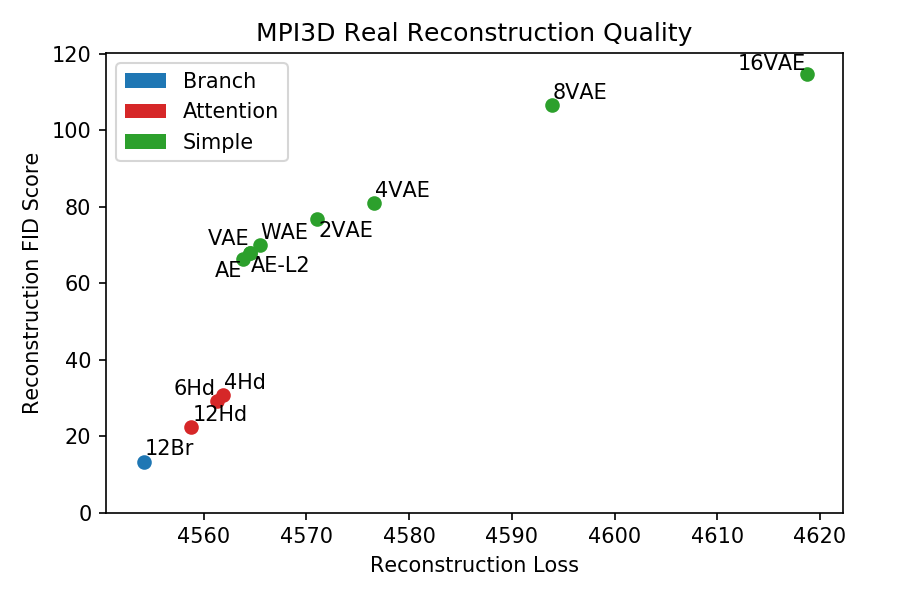

In [55]:
fig, ax = plt.subplots(figsize=fsize)
texts = []
tps = set()
for r in runs:
    plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss-(lossrg/10 if r.type == 'attn' else 0), r.fid, r.name))
    texts.append(plt.text(r.loss, r.fid, r.name))
    tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))

legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in tps]
plt.legend(handles=legend_elements)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{title} Reconstruction Quality')
# plt.xlim(left=6370)
plt.ylim(bottom=0)
plt.tight_layout()
adjust_text(texts, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
           )
pass

In [56]:
# save_fig(f'{ds}_perf')

In [57]:
def _fid(r):
    r.gen = r.data['hyb_fid']
    if 'prior_fid' in r.data:
        r.prior = r.data['prior_fid']
runs.map(_fid)
pass

In [58]:
names, hybs, typs = zip(*runs.selects('name', 'gen', 'type'))
pnames, priors, ptyps = zip(*runs.selects('name', 'prior', 'type'))
names = np.array(names + pnames)
scores = np.array(hybs + priors)
typs = np.array(typs + ptyps)
tps = np.array(['hyb']*len(hybs) + ['prior']*len(priors))
order = np.argsort(scores)
names = names[order]
scores = scores[order]
typs = typs[order]
tps = tps[order]
eclrs = [('xx' if t == 'hyb' else 'oo') for t in tps]
clrs = [colors[t] for t in typs]
len(names), len(scores)

(17, 17)

<IPython.core.display.Javascript object>


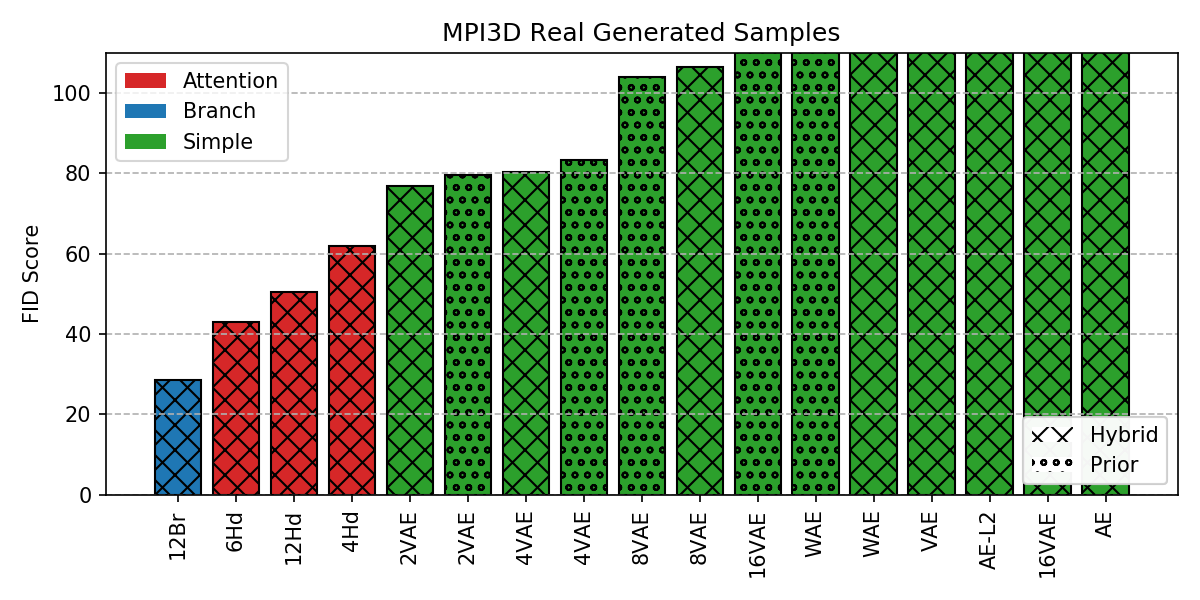

In [60]:
fig, ax = plt.subplots(figsize=(8,4))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
legend_elements = [Patch(facecolor=colors[name], label=tnames[name]) for name in set(typs)]
legend_elements1 = [Patch(facecolor='w', hatch='xx', label='Hybrid'), Patch(facecolor='w', hatch='oo', label='Prior')]
legend = plt.legend(handles=legend_elements)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{title} Generated Samples')
# plt.yscale('log')
s = [20,30,40,50,60,70, 80,90,100]
plt.ylim(top=110)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4)
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
pass

In [61]:
# save_fig(f'{ds}_gen_perf')

real_gen_perf saved


In [351]:
br = runs.filter(lambda r: r.name in {'12Br'})
# br = runs.filter(lambda r: r.name in {'12Br', '4Br', '6Br', 'VAE', '16VAE'})
len(br), list(br.selects('name', 'type'))

(0, [])

In [436]:
attn

{'4Hd': 'mpi3d-ae-12b1-4h1k32v32_0015-6346974-07_200513-020753',
 '6Hd': 'mpi3d-ae-12b1-6h1k32v32_0015-6346974-08_200513-020756',
 '12Hd': 'mpi3d-ae-12b1-12h1k32v32_0015-6346974-04_200513-020758'}

In [26]:
run = br[0]
run.rname

'3ds-ae-12b1-conv_0005-6337809-01_200509-120419'

In [7]:
rname = '3ds-ae-12b1_0052-6286534-00_200429-030431'
# rname = '3ds-vae-b32-dislib_0003-6337807-08_200509-120119'
# rname = run.rname

key = '4Hd'
key = '6Hd'
key = '12Hd'

rname = attn[key]

results = torch.load(os.path.join(root, rname, 'results.pth.tar'))

tH, tW = {'12Hd':(12,1), '6Hd':(6,2), '4Hd':(4,3)}[key]
widths = {'12Hd':[1,8], '6Hd':[1,3], '4Hd':[1,2.2]}[key]
# tH, tW = 12, 1
# tH, tW = 6,2

In [8]:
rname

'3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612'

In [9]:
A = trn.get_config()
A.din = (3, 64, 64)
A.dout = A.din
model, = trn.load(rname, config=A, get_data=None, update_config=True) # for loading only the model
print(model)

load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=point-enc)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  Creating transform (type=patch-points)
    in_shape: (3, 64, 64)
    include_coords --> coord_patches: True (in parent)
    patch_size: 4 (by default)
    stride: 2 (by default)
    dilation: 1 (by default)
    padding: 0 (by default)
  Creating pointnet (type=point-net)
    pin: 50
    latent_dim: 12 (in parent)
    n_points: 961
    modules (type=iter) with 3 elements
    Creating modules[0] (type=point-self)
      pin: 50
      pout --> key_val_dim: 64 (in parent)
      hidden --> point_tfm_hidden (type=list): 
[0]: 128
[1]: 128
[2]: 128
      nonlin: elu (in parent)
      output_nonlin: None (by default)
    Creating modules[1] (type=point-split)
      pin: 64
   

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Model on cuda
Loaded model_state from checkpoint
AutoEncoder(
  (enc): PointEncoder(
    (transform): Auto_Patch_Points(
      (transform): Unfold(kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(2, 2))
    )
    (pointnet): PointNet(
      (tfms): Sequential(
        (0): Auto_PointSelfTransform(
          (net): Sequential(
            (0): Conv1d(50, 128, kernel_size=(1,), stride=(1,))
            (1): ELU(alpha=1.0, inplace=True)
            (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
            (3): ELU(alpha=1.0, inplace=True)
            (4): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
            (5): ELU(alpha=1.0, inplace=True)
            (6): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          )
        )
        (1): Auto_PointSplitter(split=32)
        (2): Auto_PointWeightedSum(
          heads=12, keys=1
          (weights): Conv1d(32, 12, kernel_size=(1,), stride=(1,))
        )
      )
      (pool): Multihead(
        (heads): ModuleList

<IPython.core.display.Javascript object>


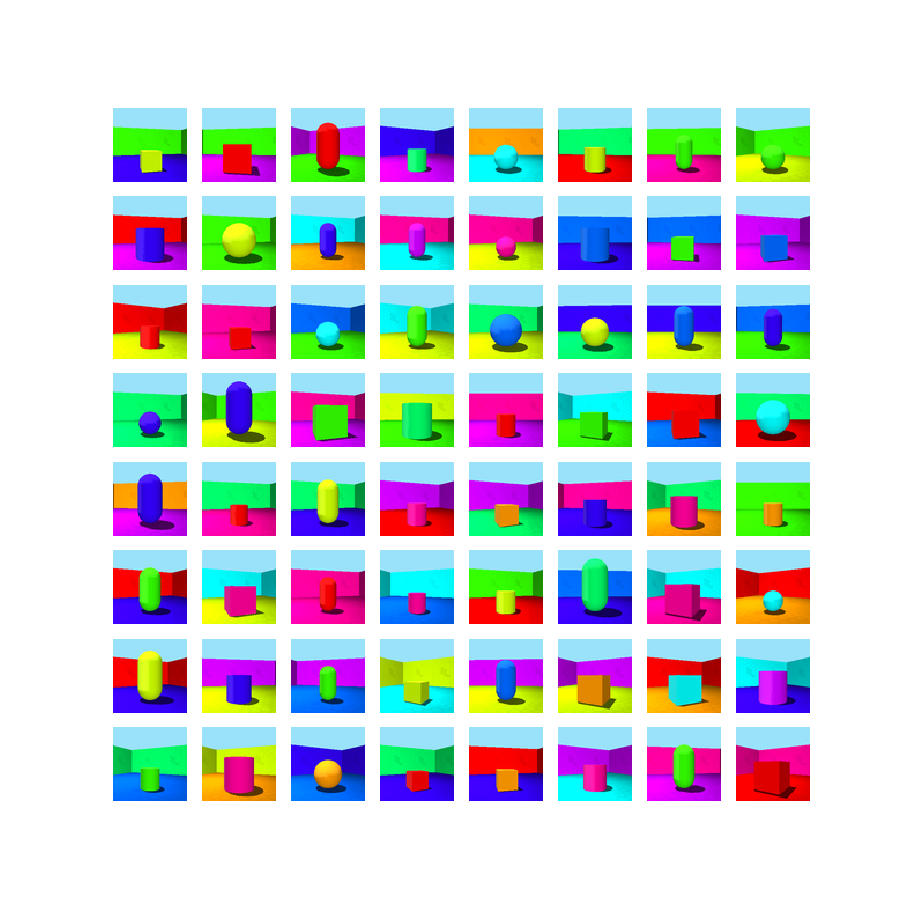

In [10]:
util.show_imgs(results['out']['original'][:64])
pass

In [11]:
bidx = 8 # 3ds
# bidx = 11 # toy

In [12]:
X = results['out']['original']
with torch.no_grad():
    Q = model.encode(X)
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[bidx]
Q.shape, q.shape

(torch.Size([128, 12]), torch.Size([12]))

In [13]:
n = 16
steps = 20
steps = 7
ntrav = 1

In [14]:
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1), Q.max(0)[0].unsqueeze(-1))).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 12, 7, 3, 64, 64])

In [15]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# full = full.permute(0, 3, 4, 1, 5, 2, 6).contiguous().view(B, S, C, tH * H, tW * W)
full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, tH, tW*H, S*W, C).squeeze(0)

full.shape

torch.Size([12, 64, 448, 3])

In [16]:
def color_ax(c):
    ax.spines['bottom'].set_color(c)
    ax.spines['top'].set_color(c) 
    ax.spines['right'].set_color(c)
    ax.spines['left'].set_color(c)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.yaxis.label.set_color(c)
    ax.xaxis.label.set_color(c)
    ax.title.set_color(c)

In [17]:
cmap = cm.get_cmap('jet')

In [18]:
# highlight = [None]*12
# highlight = ['C1']*12

# highlight = [0,1,-1,2,3,-1,-1,4,-1,-1,-1,5]
mh = max(highlight)
# hls = [(cmap(h/mh) if h >= 0 else 'k') for h in highlight]
hls = [(f'C{h}' if h >= 0 else 'k') for h in highlight]
# len(hls), hls

<IPython.core.display.Javascript object>


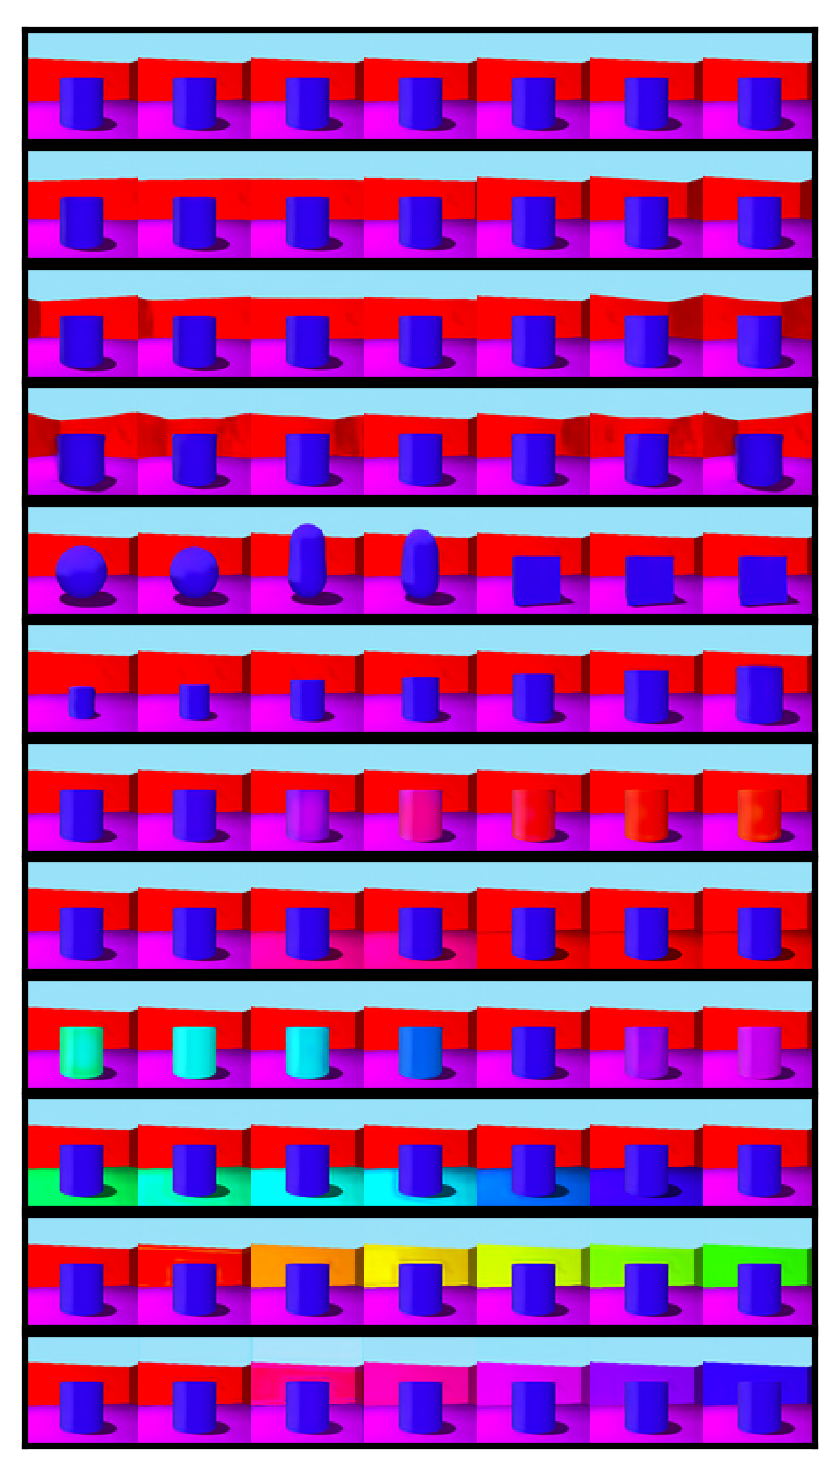

In [19]:
fig, axes = plt.subplots(tH,1, figsize=(steps*0.8,12*0.82))
for i,(ax, p, hl) in enumerate(zip(axes,full,hls)):
    plt.sca(ax)
    lw=3
    ax.spines['bottom'].set_linewidth(lw)
    ax.spines['top'].set_linewidth(lw) 
    ax.spines['right'].set_linewidth(lw)
    ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
border, between = 0.02, 0.05
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [245]:
# save_fig(f'{ds}_order')

In [296]:
# save_fig(f'{ds}_order')

In [297]:
# model#.enc.pointnet.tfms[2]

In [298]:
with torch.no_grad():
    model(X)

In [299]:
actv = model.enc.pointnet.tfms[2]._w.clone()
B, H,_,L = actv.shape
actv = actv.view(B,H,1,L)*100
actv.shape

torch.Size([128, 12, 1, 961])

In [300]:
single = actv[bidx]
avg = actv.mean(0)
single.shape, avg.shape

(torch.Size([12, 1, 961]), torch.Size([12, 1, 961]))

In [301]:
scolor = [1,0,0,]
acolor = [0,1,0]
scolor, acolor = torch.tensor(scolor).float(), torch.tensor(acolor).float()
scale = 2
scolor, acolor = scolor*scale, acolor*scale
scolor, acolor = scolor.view(1,3,1), acolor.view(1,3,1)
at = scolor*single + acolor*avg
print(at.max())
at = at.view(H,3,31,31).clamp(max=1)
at = at.permute(0,2,3,1).contiguous()
at.shape

tensor(174.8212)


torch.Size([12, 31, 31, 3])

<IPython.core.display.Javascript object>


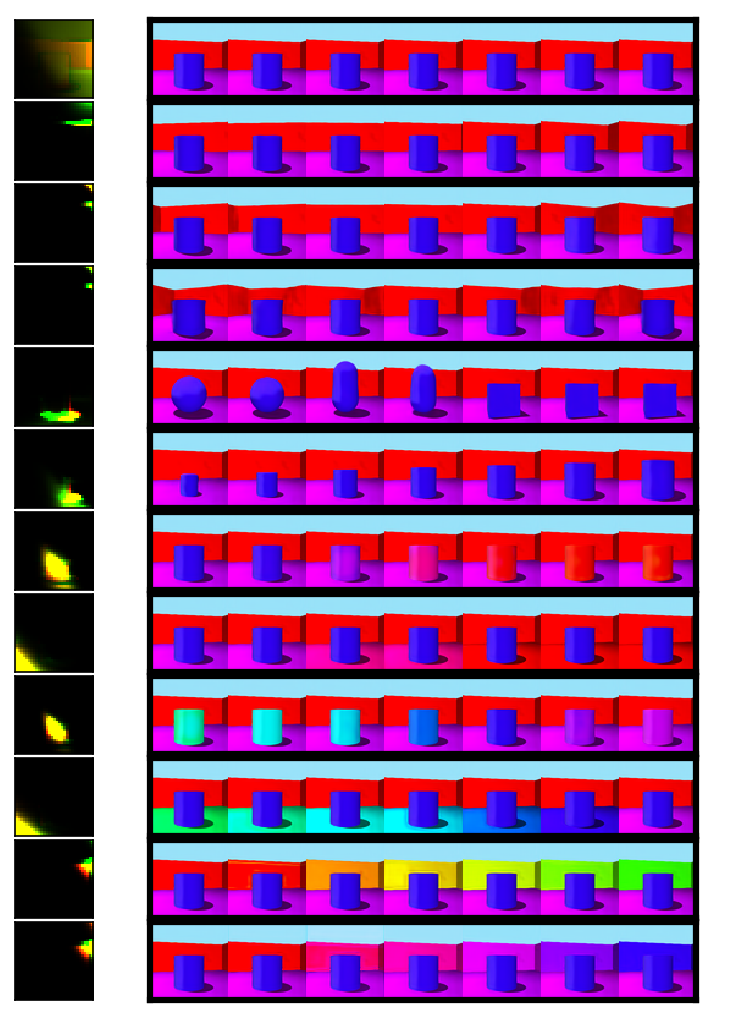

In [302]:

fig, axes = plt.subplots(tH,2, figsize=(5,6.8), gridspec_kw={'width_ratios':widths})
for i,((ac,ax), p,a) in enumerate(zip(axes,full,at)):
    plt.sca(ax)
    lw=3
    ax.spines['bottom'].set_linewidth(lw)
    ax.spines['top'].set_linewidth(lw) 
    ax.spines['right'].set_linewidth(lw)
    ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
    
    plt.sca(ac)
    plt.imshow(a.numpy())
    plt.xticks([])
    plt.yticks([])
    
border, between = 0.02, 0.05
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [303]:
# save_fig(f'{ds}_attn_{key}')

3ds_attn_12Hd saved


In [22]:
# gen

rnames = {'12Br':'3ds-ae-12b1_0052-6286534-00_200429-030431',
         'WAE':'3ds-wae-conv_0002-6337051-02_200508-232718',
         'AE':'3ds-ae-conv_0002-6337051-00_200508-232722',
          'VAE':'3ds-vae-b1-conv_0002-6337051-03_200508-232715',
         '16VAE':'3ds-vae-b16-conv_0002-6337051-07_200508-232723',
#          'VAE':'3ds-vae-b1-dislib_0003-6337807-03_200509-120115',
#          '16VAE':'3ds-vae-b32-dislib_0003-6337807-08_200509-120119',
          }


# real
rnames = {'12Br':'mpi3d-ae-12b1-conv_0012-6341580-09_200511-035033',
         'AE': 'mpi3d-ae-conv_0012-6341580-00_200511-035101',
    'WAE': 'mpi3d-wae-conv_0012-6341580-02_200511-035101',
    'VAE': 'mpi3d-ae-b1-conv_0012-6341580-01_200511-035039',
    '2VAE': 'mpi3d-vae-b2-conv_0012-6341580-04_200511-035041',
          }

# sim


rnames = {'12Br':'mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023',
          'AE': 'mpi3d-ae-conv_0011-6341579-00_200511-035009',
    'WAE': 'mpi3d-wae-conv_0011-6341579-02_200511-035010',
    'VAE': 'mpi3d-vae-b1-conv_0011-6341579-03_200511-035007',
    '2VAE': 'mpi3d-vae-b2-conv_0011-6341579-04_200511-035008',
          }

In [23]:
runs = util.Table()
for name, rname in rnames.items():
    runs.new(name=name, rname=rname)
len(runs)

5

In [24]:
def _results(r):
    path = os.path.join(os.environ['FOUNDATION_SAVE_DIR'], r.rname)
    r.results = torch.load(os.path.join(path, 'results.pth.tar'))
    r.out = r.results['out']
    if 'adv_gen.pth.tar' in os.listdir(path):
        r.gen = torch.load(os.path.join(path, 'adv_gen.pth.tar'))
runs.map(_results, pbar=tqdm)
pass

In [25]:
for run in runs:
    break
run.out.keys()

odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])

In [26]:
def _load(r):
    A = trn.get_config()
    A.din = (3, 64, 64)
    A.dout = A.din
    r.model, = trn.load(r.rname, config=A, get_data=None, update_config=True) # for loading only the model
# M.map(_load, pbar=tqdm)
for run in runs:
    _load(run)
pass

load successful


calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loaded C:\Users\anwan\Documents\workspace\trained_nets\mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [10]: 64
    [11]: 64
 

    output_nonlin --> nonlin: elu (in parent)
    residual: False (by default)
      conv_kwargs (type=dict): 
  Creating branches[7] (type=norm-ada-in)
    style_dim --> din: 1
    features: 64
    pixelwise: False (by default)
    Creating net (type=mlp) (mod=normal) (in parent)
      latent_dim: 64
      min_log_std: None (by default)
      input_dim --> din: 1
      output_dim --> dout: 128
      hidden_dims --> branch_hidden (type=list): 
[0]: 64
[1]: 128
      nonlin: elu (in parent)
      output_nonlin: None (in parent)
  Creating layers[7] (type=deconv-layer)
    in_channels: 64
    out_channels: 64
    factor: 1
    size: None (by default)
    kernel_size: None (by default)
    stride: 1 (by default)
    padding: 1 (by default)
    dilation: 1 (by default)
    output_padding: 0 (by default)
    din: (64, 16, 16)
    dout: (3, 64, 64) (in parent)
    up_type: bilinear (in parent)
    norm: group (in parent)
    nonlin: elu (in parent)
    output_nonlin --> nonlin: elu (in paren

Loaded C:\Users\anwan\Documents\workspace\trained_nets\mpi3d-vae-b1-conv_0011-6341579-03_200511-035007\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: vae
Creating encoder (type=conv) (mod=normal)
  latent_dim: 12 (in parent)
  min_log_std: None (by default)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 24
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=deconv)
  out_shape --> dout: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  nonlin: elu (in parent)
  output_nonlin: sigmoid
    channels (type=list): 
    [0]: 128
    [1]: 64
    [2]: 64
    [3]: 32
    [4]: 32
  kernels: 3
  fac

In [27]:
len(runs)

5

In [28]:
seqs = {}
i= 0
N = 10

seqs['','Original'] = run.out['original'][i:i+N]

for run in runs:
    
    with torch.no_grad():
        g = run.model.generate_hybrid(N)
        seqs[run.name, 'hybrid'] = g
        
        try:
            gp = run.model.generate_prior(N)
            seqs[run.name, 'prior'] = gp
        except:
            gp = None
    
    if 'gen' in run:
        seqs[run.name, 'gen'] = run.gen['periodic_gen'][i:i+N].contiguous()


        
for n in seqs:
#     print(n)
    g = seqs[n].cpu()
    N,C,H,W = g.shape
    g = g.permute(2,0,3,1).contiguous().view(H,N*W,C)
    seqs[n] = g
        
seqs.keys()

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


dict_keys([('', 'Original'), ('12Br', 'hybrid'), ('AE', 'hybrid'), ('WAE', 'hybrid'), ('WAE', 'prior'), ('VAE', 'hybrid'), ('VAE', 'prior'), ('2VAE', 'hybrid'), ('2VAE', 'prior')])

<IPython.core.display.Javascript object>


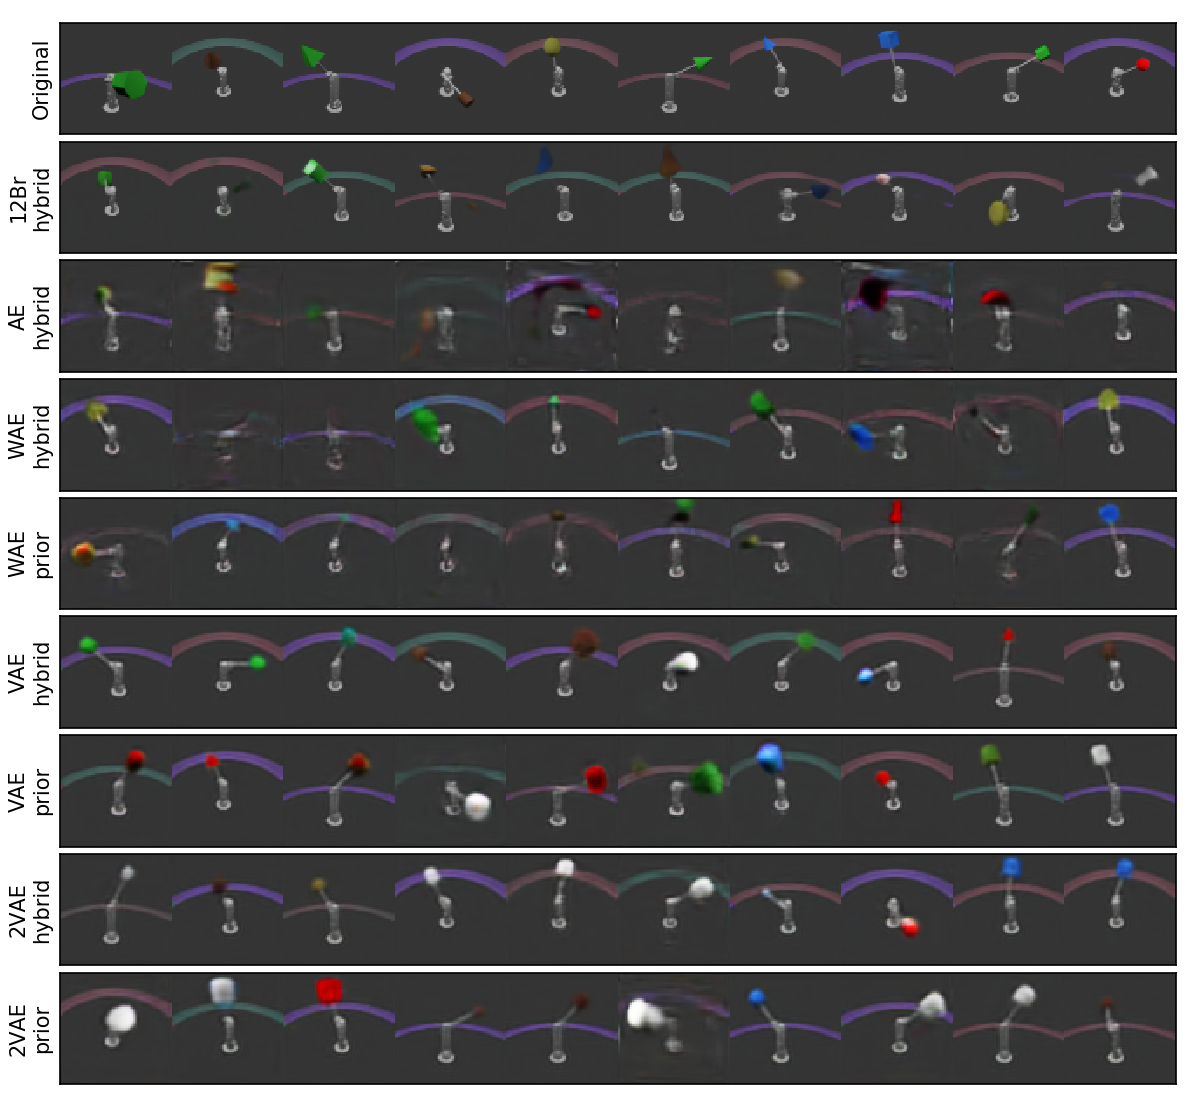

In [29]:
fig, axes = plt.subplots(len(seqs),1, figsize=(N*0.8,len(seqs)*0.82))

for i, (ax, ((n,t),g)) in enumerate(zip(axes, seqs.items())):
    
    plt.sca(ax)
    plt.imshow(g.numpy())
    plt.ylabel(f'{n}\n{t}')
    plt.xticks([])
    plt.yticks([])
border, between = 0.02, 0.05
plt.subplots_adjust(wspace=between, hspace=between,
                    left=2.5*border, right=1 - border, bottom=border, top=1 - border)

In [30]:
# save_fig('sim_gen')

sim_gen saved


In [178]:
runs = util.Table()
for n,r in attn.items():
    runs.new(name=n, rname=r)
len(runs)

3

In [180]:
for run in tqdm(runs):
    rname = run.rname
    
    if 'data' not in run:
        full = torch.load(os.path.join(root, rname, 'results.pth.tar'))
        run.data = full
    
    if 'model' not in run:
        A = trn.get_config()
        A.din = (3, 64, 64)
        A.dout = A.din
        model, = trn.load(run.rname, config=A, get_data=None, update_config=True, silent=True) # for loading only the model
        run.model = model
#     print(model)
#     break
list(runs.select('name'))

['12Hd', '4Hd', '6Hd']

In [169]:
full['out']['key_selections'].shape

torch.Size([6, 1, 31, 31])

In [181]:
model

AutoEncoder(
  (enc): PointEncoder(
    (transform): Auto_Patch_Points(
      (transform): Unfold(kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(2, 2))
    )
    (pointnet): PointNet(
      (tfms): Sequential(
        (0): Auto_PointSelfTransform(
          (net): Sequential(
            (0): Conv1d(50, 128, kernel_size=(1,), stride=(1,))
            (1): ELU(alpha=1.0, inplace=True)
            (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
            (3): ELU(alpha=1.0, inplace=True)
            (4): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
            (5): ELU(alpha=1.0, inplace=True)
            (6): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          )
        )
        (1): Auto_PointSplitter(split=32)
        (2): Auto_PointWeightedSum(
          heads=6, keys=1
          (weights): Conv1d(32, 6, kernel_size=(1,), stride=(1,))
        )
      )
      (pool): Multihead(
        (heads): ModuleList(
          (0): MLP(
            (net): Sequential

In [ ]:
shape = (31,31)

In [182]:
model.enc.pointnet.tfms[2]

Auto_PointWeightedSum(
  heads=6, keys=1
  (weights): Conv1d(32, 6, kernel_size=(1,), stride=(1,))
)